In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ========== 1. Load MNIST Data ==========
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Split into train (80%), val (10%), test (10%)
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ========== 2. Define RNN Model ==========
class RNNModel(nn.Module):
    def __init__(self, input_size=28, hidden_size=64, num_layers=1, output_size=10):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Output layer
    
    def forward(self, x):
        out, _ = self.rnn(x)  # Output: (Batch, Sequence, Hidden)
        out = self.fc(out[:, -1, :])  # Take last time step
        return out

# Instantiate Model
model = RNNModel(input_size=28, hidden_size=64, num_layers=1, output_size=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ========== 3. Train RNN Model ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store loss and accuracy for plotting
train_losses, val_losses = [], []
train_accs, val_accs = [], []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.view(X_batch.size(0), 28, 28)  # Reshape (B, 1, 28, 28) → (B, 28, 28)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += predicted.eq(y_batch).sum().item()
    
    train_acc = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.view(X_batch.size(0), 28, 28)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()

    val_acc = correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

# ========== 4. Evaluate on Test Set ==========
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch = X_batch.view(X_batch.size(0), 28, 28)  # Reshape (B, 1, 28, 28) → (B, 28, 28)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Epoch [1/20] - Train Loss: 0.9156, Train Acc: 0.6834 | Val Loss: 0.6130, Val Acc: 0.7967
Epoch [2/20] - Train Loss: 0.4491, Train Acc: 0.8626 | Val Loss: 0.3664, Val Acc: 0.8893
Epoch [3/20] - Train Loss: 0.3338, Train Acc: 0.9022 | Val Loss: 0.2877, Val Acc: 0.9143
Epoch [4/20] - Train Loss: 0.2826, Train Acc: 0.9177 | Val Loss: 0.2659, Val Acc: 0.9285
Epoch [5/20] - Train Loss: 0.2615, Train Acc: 0.9247 | Val Loss: 0.2392, Val Acc: 0.9290
Epoch [6/20] - Train Loss: 0.2391, Train Acc: 0.9317 | Val Loss: 0.2639, Val Acc: 0.9235
Epoch [7/20] - Train Loss: 0.2250, Train Acc: 0.9357 | Val Loss: 0.2294, Val Acc: 0.9350
Epoch [8/20] - Train Loss: 0.2111, Train Acc: 0.9398 | Val Loss: 0.2190, Val Acc: 0.9390
Epoch [9/20] - Train Loss: 0.2000, Train Acc: 0.9436 | Val Loss: 0.2137, Val Acc: 0.9413
Epoch [10/20] - Train Loss: 0.1924, Train Acc: 0.9453 | Val Loss: 0.1966, Val Acc: 0.9450
Epoch [11/20] - Train Loss: 0.1864, Train Acc: 0.9475 | Val Loss: 0.2158, Val Acc: 0.9398
Epoch [12/20] - Tra

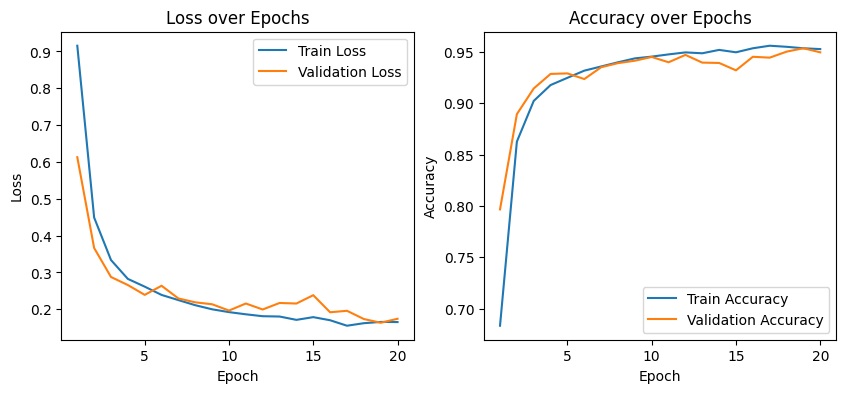

In [5]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.show()